# Deep Dreams

Work in progress. Attempting to turn a keras model into a conx model.

<table>
    <tr>
        <td><img src="monalisa.jpg" width="200px"></td>
        <td><img src="monalisa-generated.png" width="200px"></td>
    </tr>
</table>

In [1]:
from keras import backend as K
from keras.applications import inception_v3
from keras.preprocessing.image import load_img, img_to_array
import keras

import numpy as np
import scipy
from IPython.display import Image

Using Theano backend.


In [2]:
base_image_path = "monalisa.jpg"
result_prefix = "monoalisa-generated.png"

These are the names of the layers for which we try to maximize activation, as well as their weight in the final loss we try to maximize.

You can tweak these setting to obtain new visual effects.

In [3]:
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}

In [4]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)

In [5]:
K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')

Model loaded.


In [6]:
from conx import import_keras_model

conx, version 3.4.0


In [7]:
network = import_keras_model(model, "Inception V3")

In [8]:
for clayer in network.layers:
    if clayer.kind() == "hidden":
        clayer.visible = False

In [9]:
img = preprocess_image(base_image_path)

In [10]:
network.dataset._inputs = [img]

In [14]:
network.layers[0].visible = False

<IPython.core.display.Javascript object>

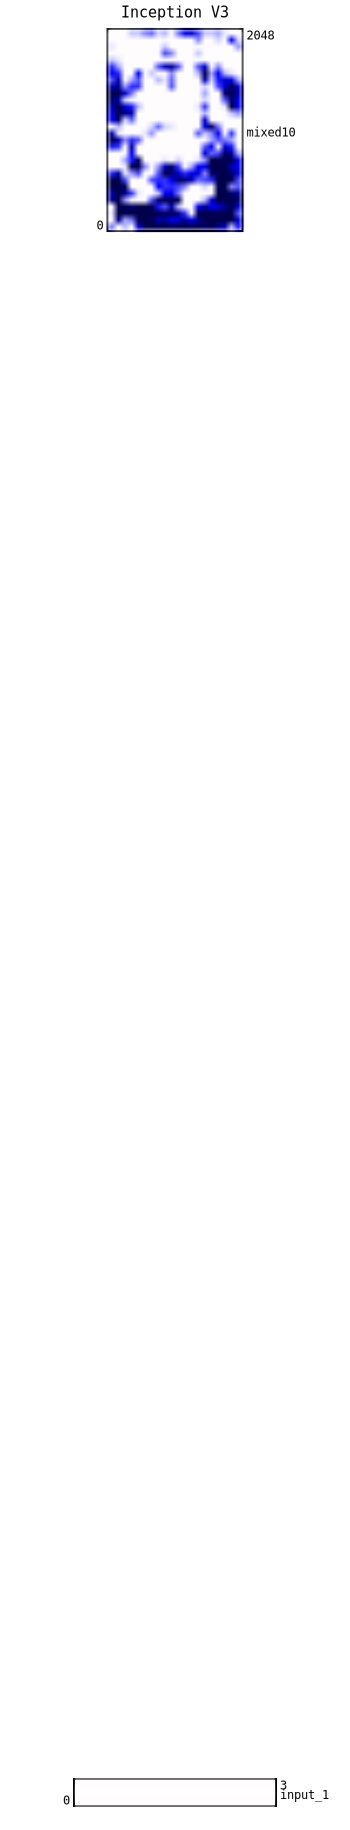

In [11]:
from IPython.display import SVG
SVG(network.build_svg(opts={"svg_height": 2000}))

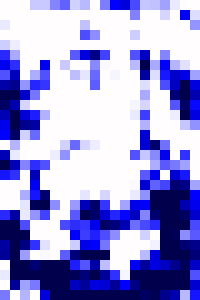

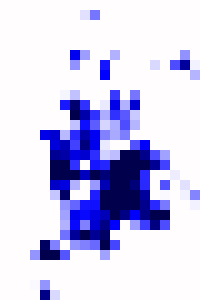

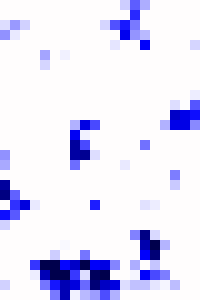

In [12]:
from IPython.display import display
for i in range(3):
    network["mixed10"].feature = i
    display(network.propagate_to_image("mixed10", img[0]).resize((200, 300)))

In [13]:
output = network.propagate(img[0])

In [14]:
from conx import shape
shape(output)

(30, 20, 2048)

In [15]:
network.layers[1].name

'conv2d_1'

In [16]:
output = network.propagate_to("conv2d_1", img[0])

In [18]:
shape(output)

(511, 343, 32)

In [32]:
Shape(network.dataset.inputs[0])

(1024, 687, 3)

In [ ]:
# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

Process:

- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.

To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.

In [ ]:
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10.

if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

In [ ]:
output1 = model.predict(img)[0]

In [ ]:
output2 = network.propagate(img[0])

In [ ]:
(output1 == output2).all()

In [ ]:
from conx import shape as Shape
Shape(output2)

In [ ]:
## Exploring the output:

In [ ]:
for i in range(10):
    display(array2image(output1[[slice(None, None), slice(None, None), i]]).resize((200, 300)))

In [ ]:
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

save_img(img, fname=result_prefix + '.png')

In [ ]:
Image(filename="./monalisa-generated.png")